In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import boxcox

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load Delhi stations data
df = pd.read_csv('data/generated/delhi_stations_hourly.csv')

# Load only the "file_name", "latitude", and "longitude" columns from "delhi_stations_info.csv"
lat_lon_df = pd.read_csv("data/delhi_stations_info.csv", usecols=["file_name", "latitude", "longitude"])

# Merge the DataFrames based on the common column "StationId" in "df" and "file_name" in "lat_lon_df"
df = pd.merge(df, lat_lon_df, left_on="StationId", right_on="file_name", how="left")

# Drop the redundant "file_name" column
df = df.drop("file_name", axis=1)

df.head()

,Datetime,StationId,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ug/m3),NH3 (ug/m3),SO2 (ug/m3),CO (ug/m3),...,RH (%),WS (m/s),WD (degree),BP (mmHg),AT (degree C),RF (mm),SR (W/mt2),AQI,latitude,longitude
0,2020-11-28 00:00:00,DL004,68.850000,242.810000,18.430000,39.450000,35.730000,63.330000,7.770000,0.440000,...,73.620000,0.250000,218.980000,NaN,14.740000,0.0,4.380000,NaN,28.60909,77.032541
1,2020-11-28 01:00:00,DL004,116.314167,196.385993,21.800417,47.558600,48.732917,38.778182,9.790615,1.106522,...,68.729524,0.800000,217.970909,981.320556,17.485455,0.0,5.183810,NaN,28.60909,77.032541
2,2020-11-28 02:00:00,DL004,118.085745,196.181544,21.502340,49.366855,48.110000,38.363488,10.031594,1.106522,...,69.821707,0.830976,209.814186,981.070556,17.294884,0.0,5.178049,NaN,28.60909,77.032541
3,2020-11-28 03:00:00,DL004,121.146667,195.504038,18.938358,49.432938,44.364478,37.339508,10.039609,1.083125,...,70.480833,0.900167,210.963016,980.915556,17.177302,0.0,5.129167,NaN,28.60909,77.032541
4,2020-11-28 04:00:00,DL004,126.420870,194.864346,15.099394,48.631877,38.598788,36.644667,9.976959,1.011250,...,71.726667,0.992500,207.958254,980.621111,16.844286,0.0,5.031167,NaN,28.60909,77.032541


In [3]:
# Convert the 'Datetime' column to a pandas datetime object
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Sort the DataFrame by 'Datetime' to extract various feature set
df = df.sort_values(by=['StationId', 'Datetime'])

# Extract year from the 'Datetime' column
# df['Year'] = df['Datetime'].dt.year

# Add a new column 'Month' with month names
# df['Month'] = df['Datetime'].dt.strftime('%B')
df['Month'] = df['Datetime'].dt.month

# Add a new column 'DayOfWeek'
# df['DayOfWeek'] = df['Datetime'].dt.day_name()
df['DayOfWeek'] = df['Datetime'].dt.dayofweek

# Add a new column 'HourOfDay'
df['HourOfDay'] = df['Datetime'].dt.hour

# Calculate volatilities for daily, weekly, and monthly rolling windows per station
df['Volatility_Last_24hr'] = df.groupby('StationId')['AQI'].rolling(window=24).std().reset_index(level=0, drop=True)
df['Volatility_Last_7d'] = df.groupby('StationId')['AQI'].rolling(window=24 * 7).std().reset_index(level=0, drop=True)
df['Volatility_Last_30d'] = df.groupby('StationId')['AQI'].rolling(window=24 * 30).std().reset_index(level=0, drop=True)

df['MA_Last_7d'] = df.groupby('StationId')['AQI'].rolling(window=24 * 7).mean().reset_index(level=0, drop=True)
df['MA_Last_30d'] = df.groupby('StationId')['AQI'].rolling(window=24 * 30).mean().reset_index(level=0, drop=True)

# Next 24 hour AQI (the 'y' variable)
df['y_AQI'] = df['AQI'].shift(periods=-24)
df = df.dropna(subset=['y_AQI'])

df.head()

,Datetime,StationId,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ug/m3),NH3 (ug/m3),SO2 (ug/m3),CO (ug/m3),...,longitude,Month,DayOfWeek,HourOfDay,Volatility_Last_24hr,Volatility_Last_7d,Volatility_Last_30d,MA_Last_7d,MA_Last_30d,y_AQI
0,2020-11-28 00:00:00,DL004,68.850000,242.810000,18.430000,39.450000,35.730000,63.330000,7.770000,0.440000,...,77.032541,11,5,0,NaN,NaN,NaN,NaN,NaN,215.0
1,2020-11-28 01:00:00,DL004,116.314167,196.385993,21.800417,47.558600,48.732917,38.778182,9.790615,1.106522,...,77.032541,11,5,1,NaN,NaN,NaN,NaN,NaN,213.0
2,2020-11-28 02:00:00,DL004,118.085745,196.181544,21.502340,49.366855,48.110000,38.363488,10.031594,1.106522,...,77.032541,11,5,2,NaN,NaN,NaN,NaN,NaN,212.0
3,2020-11-28 03:00:00,DL004,121.146667,195.504038,18.938358,49.432938,44.364478,37.339508,10.039609,1.083125,...,77.032541,11,5,3,NaN,NaN,NaN,NaN,NaN,209.0
4,2020-11-28 04:00:00,DL004,126.420870,194.864346,15.099394,48.631877,38.598788,36.644667,9.976959,1.011250,...,77.032541,11,5,4,NaN,NaN,NaN,NaN,NaN,206.0


In [4]:
# Filter records before "2021-01-01"
df = df[df['Datetime'] >= "2021-01-01"]

# Sort the DataFrame by 'Datetime' to apply rolling window across stations
df = df.sort_values(by=['Datetime', 'StationId'])

# Reset the index of the DataFrame
df = df.reset_index(drop=True)

df.head()

,Datetime,StationId,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ug/m3),NH3 (ug/m3),SO2 (ug/m3),CO (ug/m3),...,longitude,Month,DayOfWeek,HourOfDay,Volatility_Last_24hr,Volatility_Last_7d,Volatility_Last_30d,MA_Last_7d,MA_Last_30d,y_AQI
0,2021-01-01,DL004,363.873333,327.733876,137.860580,49.843756,153.558696,60.277424,9.421631,3.591000,...,77.032541,1,4,0,17.256326,48.130540,97.872474,277.660714,299.656944,444.0
1,2021-01-01,DL007,363.873333,328.043690,137.860580,49.864090,153.558696,60.277424,9.425902,3.591000,...,77.201157,1,4,0,13.934370,48.578413,66.307935,350.577381,359.443056,517.0
2,2021-01-01,DL011,365.559583,328.357307,138.026667,49.884244,153.490870,60.277424,9.430173,3.601857,...,77.109936,1,4,0,6.173224,55.296431,71.839095,298.702381,296.847222,471.0
3,2021-01-01,DL014,366.236667,328.671352,138.017681,49.904217,153.309710,60.332273,9.434156,3.607571,...,77.131023,1,4,0,28.097366,56.985763,78.837344,346.255952,364.241667,680.0
4,2021-01-01,DL016,367.736389,328.989126,141.738261,49.925545,150.962941,60.332273,9.438139,3.636143,...,77.118005,1,4,0,7.459553,60.041259,98.204325,318.369048,326.927778,448.0


In [5]:
# Handle skewness in the data (DON'T RUN THIS CODE TWICE)
# Apply "log transformation" for right-skewed data
df['PM2.5 (ug/m3)'] = np.log1p(df['PM2.5 (ug/m3)'])
df['NO (ug/m3)'] = np.log1p(df['NO (ug/m3)'])
df['NOx (ug/m3)'] = np.log1p(df['NOx (ug/m3)'])
df['SO2 (ug/m3)'] = np.log1p(df['SO2 (ug/m3)'])
df['CO (ug/m3)'] = np.log1p(df['CO (ug/m3)'])
df['Benzene (ug/m3)'] = np.log1p(df['Benzene (ug/m3)'])
df['Toluene (ug/m3)'] = np.log1p(df['Toluene (ug/m3)'])
df['Volatility_Last_24hr'] = np.log1p(df['Volatility_Last_24hr'])

# Apply "square root transformation" for left-skewed data

# Apply "box-cox transformation" for varying degrees of skewness
df['Volatility_Last_7d'], _ = boxcox(df['Volatility_Last_7d'])
df['Volatility_Last_30d'], _ = boxcox(df['Volatility_Last_30d'])

In [6]:
df.head()

,Datetime,StationId,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ug/m3),NH3 (ug/m3),SO2 (ug/m3),CO (ug/m3),...,longitude,Month,DayOfWeek,HourOfDay,Volatility_Last_24hr,Volatility_Last_7d,Volatility_Last_30d,MA_Last_7d,MA_Last_30d,y_AQI
0,2021-01-01,DL004,5.899550,327.733876,4.933470,49.843756,5.040574,60.277424,2.343884,1.524098,...,77.032541,1,4,0,2.904512,7.773454,18.441287,277.660714,299.656944,444.0
1,2021-01-01,DL007,5.899550,328.043690,4.933470,49.864090,5.040574,60.277424,2.344293,1.524098,...,77.201157,1,4,0,2.703665,7.806220,14.757339,350.577381,359.443056,517.0
2,2021-01-01,DL011,5.904161,328.357307,4.934666,49.884244,5.040135,60.277424,2.344703,1.526460,...,77.109936,1,4,0,1.970355,8.274940,15.456633,298.702381,296.847222,471.0
3,2021-01-01,DL014,5.906007,328.671352,4.934601,49.904217,5.038962,60.332273,2.345085,1.527701,...,77.131023,1,4,0,3.370648,8.386697,16.304736,346.255952,364.241667,680.0
4,2021-01-01,DL016,5.910082,328.989126,4.961013,49.925545,5.023637,60.332273,2.345466,1.533883,...,77.118005,1,4,0,2.135296,8.583285,18.476640,318.369048,326.927778,448.0


In [7]:
# Get all columns except Datetime, StationId and y_AQI
# X_columns = df.drop([
#     'Datetime', 'StationId', 'y_AQI', 'Volatility_Last_7d', 'RF (mm)', 'PM2.5 (ug/m3)', 'DayOfWeek', 'HourOfDay', 'Volatility_Last_24hr', 'SO2 (ug/m3)', 'Month',
#     'MA_Last_30d', 'Volatility_Last_30d', 'Ozone (ug/m3)', 'NO (ug/m3)', 'Benzene (ug/m3)', 'RH (%)', 'PM10 (ug/m3)',
#     'NOx (ug/m3)', 'NH3 (ug/m3)', 'Toluene (ug/m3)'
#     ], axis=1).columns.tolist()
X_columns = df.drop(['Datetime', 'StationId', 'y_AQI'], axis=1).columns.tolist()
X = df[X_columns]
y = df['y_AQI']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# # Set your specific Datetime threshold
# datetime_threshold = pd.to_datetime('2023-01-01')

# # Select records based on your criteria
# train_data = df[df['Datetime'] < datetime_threshold]
# test_data = df[df['Datetime'] >= datetime_threshold]

# # Separate features (X) and target variable (y) for train and test data
# X_train = train_data[X_columns]
# y_train = train_data['y_AQI']
# X_test = test_data[X_columns]
# y_test = test_data['y_AQI']

# Initialize the scaler and fit on the training data
scaler = MinMaxScaler()

# Transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train) # X_train # scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # X_test # scaler.transform(X_test)

In [9]:
# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# 1. Evaluate the Model Performance

In [10]:
# Mean Squared Error (MSE): Evaluate how well the model predicts by calculating the MSE.
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 3246.586012561767


2420.924784295189 - without any scaling or feature removal (Doesn't change this value even after scaling)

3246.586012561767 - after AQI Fix

In [11]:
# R-squared (R2): Measures the proportion of the variance in the dependent variable explained by the independent variables
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

R-squared: 0.7884956742542651


0.8237883646911426 - without any scaling or feature removal (Doesn't change this value even after scaling)

0.7884956742542651 - after AQI Fix

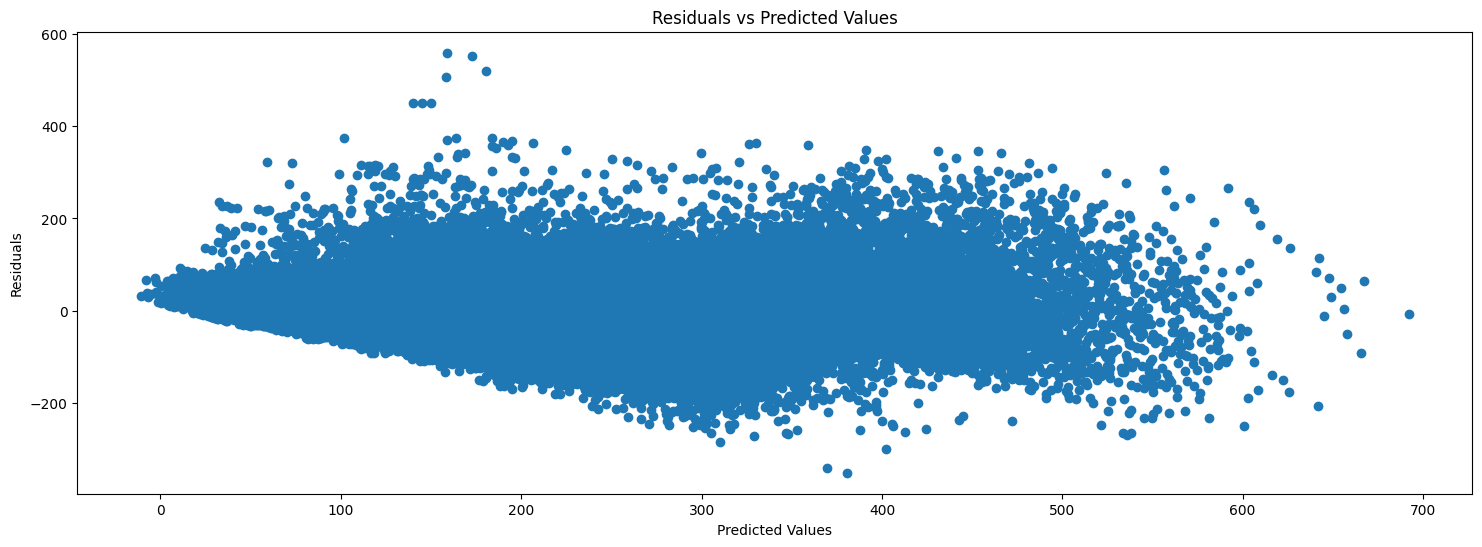

In [12]:
# Plot residuals (the differences between observed and predicted values) against predicted values to check for patterns or heteroscedasticity
residuals = y_test - y_pred
plt.figure(figsize=(18, 6))
plt.scatter(y_pred, residuals)
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

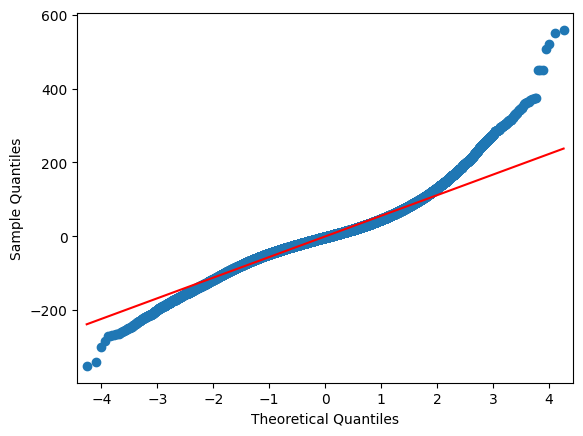

In [13]:
# Check if residuals are normally distributed using a Q-Q plot.
import statsmodels.api as sm
sm.qqplot(residuals, line='r')
plt.show()

# 2. Evaluate the Feature Importance

In [14]:
# Check the coefficients of the features to understand their impact.
coefficients = model.coef_
feature_names = X.columns
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

feature_importance_sorted = feature_importance.sort_values(by='Coefficient').reset_index(drop=True)

print(feature_importance_sorted)

                 Feature  Coefficient
0               WS (m/s)   -68.251917
1           PM10 (ug/m3)   -60.350887
2            NOx (ug/m3)   -49.765920
3          AT (degree C)   -44.226294
4            NH3 (ug/m3)   -33.943126
5                 RH (%)   -33.672262
6     Volatility_Last_7d   -23.772317
7        Toluene (ug/m3)   -23.061570
8                RF (mm)   -17.146240
9            SO2 (ug/m3)    -6.575791
10  Volatility_Last_24hr    -5.356830
11             DayOfWeek    -4.190057
12             HourOfDay    -2.371337
13             longitude     2.986800
14            SR (W/mt2)     3.926910
15                 Month    11.267590
16              latitude    13.249371
17           NO2 (ug/m3)    20.713861
18           MA_Last_30d    22.894925
19       Benzene (ug/m3)    26.199138
20           WD (degree)    31.685394
21   Volatility_Last_30d    42.760151
22             BP (mmHg)    45.863777
23            NO (ug/m3)    55.601201
24         Ozone (ug/m3)    73.513795
25          

                 Feature  Coefficient
0          PM2.5 (ug/m3)    -1.303606
1           PM10 (ug/m3)     0.101278
2             NO (ug/m3)     6.771116
3            NO2 (ug/m3)     1.236757
4            NOx (ug/m3)   -26.196374
5            NH3 (ug/m3)    -0.764988
6            SO2 (ug/m3)     9.956806
7             CO (ug/m3)    75.074236
8          Ozone (ug/m3)     0.515249
9        Benzene (ug/m3)    24.799078
10       Toluene (ug/m3)   -23.937790
11                RH (%)     0.714299
12              WS (m/s)   -20.231899
13           WD (degree)     0.315888
14             BP (mmHg)     0.410136
15         AT (degree C)    -2.808314
16               RF (mm)    -9.191047
17            SR (W/mt2)     0.352819
18                   AQI     0.365018
19                 Month     1.973615
20             DayOfWeek    -0.589304
21             HourOfDay    -0.028377
22  Volatility_Last_24hr     2.557974
23    Volatility_Last_7d    -2.651911
24   Volatility_Last_30d     1.742751
25            MA_Last_7d     0.170197
26           MA_Last_30d     0.073799

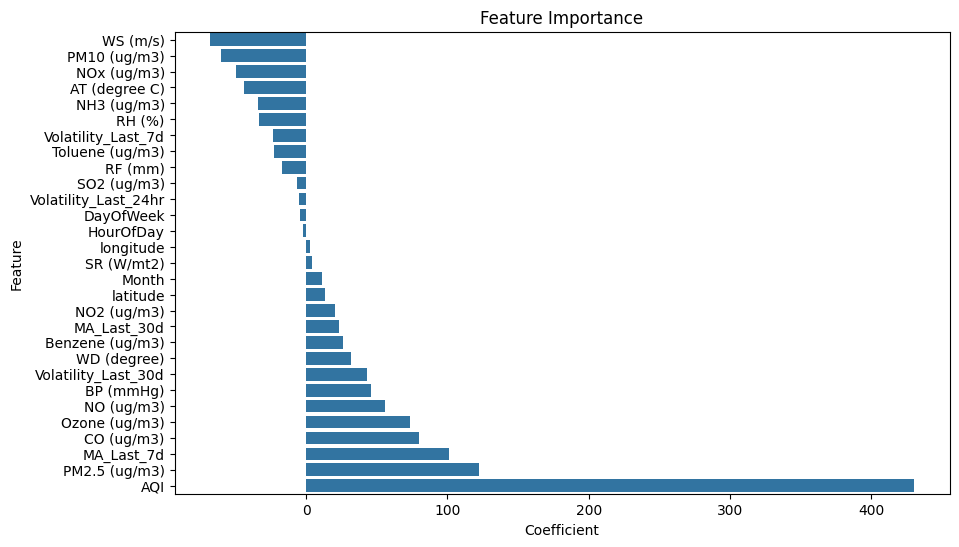

In [15]:
# Visualize the coefficients.
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance.sort_values(by='Coefficient'))
plt.title('Feature Importance')
plt.show()

In [16]:
X.head()

,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ug/m3),NH3 (ug/m3),SO2 (ug/m3),CO (ug/m3),Ozone (ug/m3),Benzene (ug/m3),...,latitude,longitude,Month,DayOfWeek,HourOfDay,Volatility_Last_24hr,Volatility_Last_7d,Volatility_Last_30d,MA_Last_7d,MA_Last_30d
0,5.899550,327.733876,4.933470,49.843756,5.040574,60.277424,2.343884,1.524098,10.713194,2.238454,...,28.609090,77.032541,1,4,0,2.904512,7.773454,18.441287,277.660714,299.656944
1,5.899550,328.043690,4.933470,49.864090,5.040574,60.277424,2.344293,1.524098,10.713194,2.238454,...,28.725650,77.201157,1,4,0,2.703665,7.806220,14.757339,350.577381,359.443056
2,5.904161,328.357307,4.934666,49.884244,5.040135,60.277424,2.344703,1.526460,10.711806,2.238454,...,28.470691,77.109936,1,4,0,1.970355,8.274940,15.456633,298.702381,296.847222
3,5.906007,328.671352,4.934601,49.904217,5.038962,60.332273,2.345085,1.527701,10.783056,2.242210,...,28.674045,77.131023,1,4,0,3.370648,8.386697,16.304736,346.255952,364.241667
4,5.910082,328.989126,4.961013,49.925545,5.023637,60.332273,2.345466,1.533883,10.789444,2.242210,...,28.562776,77.118005,1,4,0,2.135296,8.583285,18.476640,318.369048,326.927778


In [17]:
# column = 'NO (ug/m3)'
# X_TEST = X[[column]].copy()
# X_TEST[column] = np.log1p(X_TEST[column])     # right-skewed      - logarithm
# # X_TEST[column] = np.sqrt(X_TEST[column])      # left-skewed       - Square root
# # X_TEST[column] = X_TEST[column] ** (1/3)      # left-skewed       - Cube root
# # X_TEST[column], _ = boxcox(X_TEST[column])    # varying-skewness  - boxcox
# # X_TEST[column] = X_TEST[column] * 9999999
# X_TEST.head()

In [18]:
# # Convert y_pred to a DataFrame
# # X_test_df = pd.DataFrame(scaler.transform(X_test), columns=X_columns)
# # y_test_df = pd.DataFrame({'y_AQI': y_test})
# y_pred_df = pd.DataFrame({'y_pred': y_pred})

# # Concatenate the DataFrames along the columns (axis=1)
# result_df = pd.concat([X_test, y_test, y_pred_df], axis=1)

# result_df.head()

In [19]:
chart_df = df
# stations_to_include = ['DL004', 'DL007', 'DL033', 'DL030', 'DL031', 'DL040']       #### 'DL033', 'DL007', 'DL008', 'DL021', 'DL013', 'DL014', 'DL002', 'DL031', 'DL028', 'DL019'
# chart_df = df[df['StationId'].isin(stations_to_include)].copy()
# chart_df.reset_index(drop=True, inplace=True)

# Extract Year and Month from 'Datetime'
chart_df['Datetime'] = pd.to_datetime(chart_df['Datetime'])

# Create 'Year_Month' column with the 1st day of every month
chart_df['Datetime'] = chart_df['Datetime'].dt.to_period('M').dt.to_timestamp()

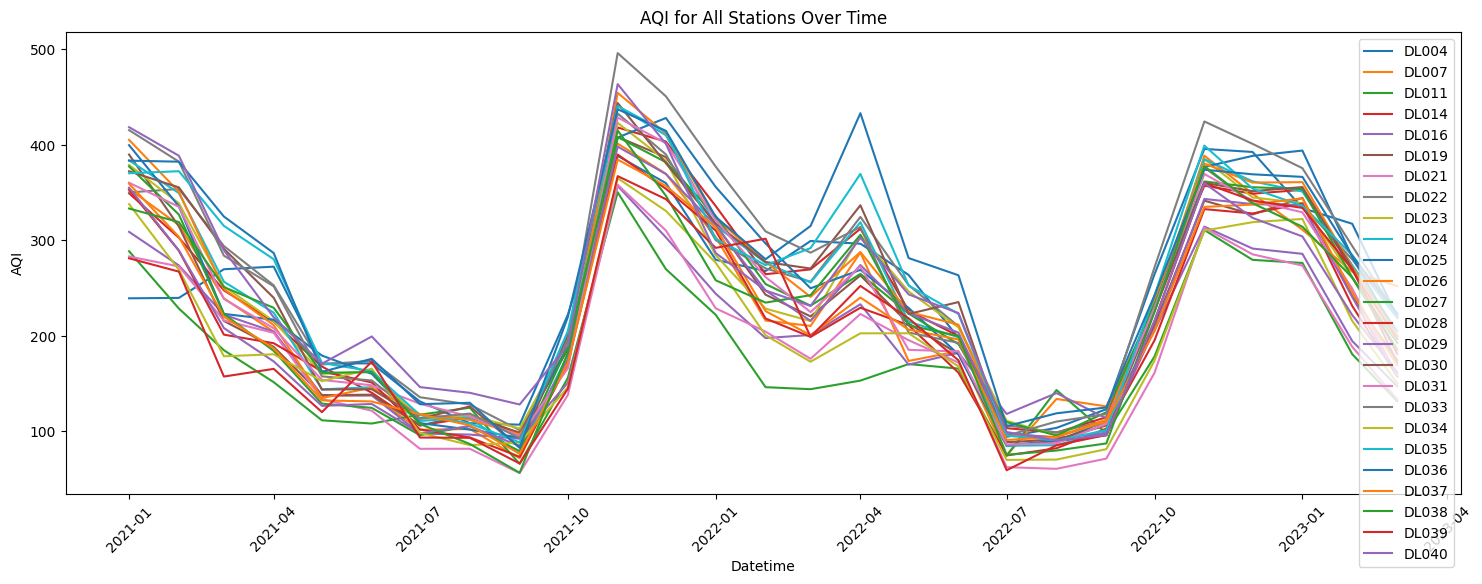

In [20]:
# Group by 'StationId' and 'Year_Month', calculate mean AQI
chart_df_2 = chart_df.groupby(['StationId', 'Datetime'])['AQI'].mean().reset_index()

# Create a line chart for each StationId
plt.figure(figsize=(18, 6))

# Plot AQI for each station
for station_id in chart_df_2['StationId'].unique():
    station_data = chart_df_2[chart_df_2['StationId'] == station_id]
    plt.plot(station_data['Datetime'], station_data['AQI'], label=station_id)

# Customize the plot
plt.title('AQI for All Stations Over Time')
plt.xlabel('Datetime')
plt.ylabel('AQI')
plt.xticks(rotation=45)
plt.legend()
plt.show()